In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares, curve_fit
from scipy.stats import poisson, chi2, f
from scipy.special import gamma

In [2]:
data = np.genfromtxt('pendulum_data.csv', delimiter=',', usecols=1, skip_header=1)

In [3]:
sample_mean = np.mean(data)
sample_std_dev = np.std(data)
uncertainty_in_estimated_parent_pop_mean = sample_std_dev**2/len(data)
print("Sample mean:",sample_mean)
print("Sample std:",sample_std_dev)
print("Estimated mean is just sample mean, and it has uncertainty", uncertainty_in_estimated_parent_pop_mean)

Sample mean: 9.853104125893749
Sample std: 0.6618345337685915
Estimated mean is just sample mean, and it has uncertainty 0.0009125519793514351


In [4]:
from scipy.stats import norm

bins = np.linspace(6, 16, num=37)
bin_width = bins[1] - bins[0]

x_gaussian = np.linspace(min(bins), max(bins), 100)

# Calculate y-values for the Gaussian PDF
y_gaussian = bin_width*len(data)*norm.pdf(x_gaussian, loc=sample_mean, scale=sample_std_dev)

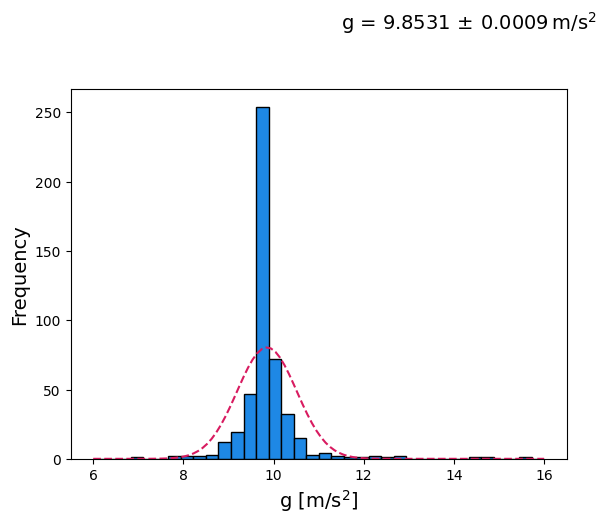

In [5]:
# plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# plt.rc('text', usetex=True)

hist_counts, bin_edges = plt.hist(data,bins=bins, color = '#1E88E5', edgecolor='black')[:2]
plt.plot(x_gaussian, y_gaussian, color='#D81B60', linestyle='--', label='Gaussian Fit')
plt.xlabel("g [m/s$^2$]", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
s = "g = " + str(round(sample_mean,4)) + "$\\, \\pm \\,$" + str(round(uncertainty_in_estimated_parent_pop_mean,4)) + "$\\,$m/s$^2$"
# Annotate the plot with text indicating the mean, its uncertainty, and the total number of counts.


plt.text(11.5, 310, s, fontsize=14)
plt.savefig('JLab_Hist.pdf')

plt.show()


In [6]:
# TODO: Code I did not use but is probably more generalizable and pedagogical, so I should try
# # BASE FITTERS

# class BaseFitter:
#     def __init__(self, x, y, yerr, xerr=None):
#         self.x = x
#         self.y = y
#         self.yerr = yerr
#         self.xerr = xerr

#         if self.xerr is not None:
#             self.dx = (self.x.max() - self.x.min()) / 1000

#     def _normalize(self,x):
#         return x.mean(), x.std()

#     def _get_model(self, x, params):
#         raise NotImplementedError("Not implemented in base class.")
    
#     def _get_residuals(self, params):
#         yhat = self._get_model(self.x,params)
#         if self.xerr is not None:
#             dyhat_dx = (self._get_model(self.x + self.dx,params) - self._get_model(self.x - self.dx,params)) / (2*self.dx)
            
#             sigma = np.sqrt(self.yerr**2 + dyhat_dx**2 * self.xerr**2)
#         else:
#             sigma = self.yerr
        
#         return (self.y - yhat) / sigma
    
#     def _get_chisqr(self, params):
#         return np.sum(self._get_residuals(params)**2)
    
#     def _get_initial_guess(self):
#         raise NotImplementedError("Not implemented in base class.")
    
#     def fit(self,bounds=(-np.inf,np.inf)):
#         initial_guess = self._get_initial_guess()
#         print(self._get_residuals, initial_guess)
#         result = least_squares(
#             self._get_residuals, initial_guess, bounds=bounds
#         )

#         chisqr = self._get_chisqr(result.x)
#         alpha = 1 - chi2.cdf(chisqr, len(self.x) - len(result.x))

#         try:
#             cov = np.linalg.inv(np.dot(result.jac.T, result.jac))
#             e_params = np.sqrt(np.diagonal(cov))
#         except np.linalg.LinAlgError:
#             cov = None
#             e_params = None

#         return {
#             'params': result.x,
#             'e_params': e_params,

#             'chisqr': self._get_chisqr(result.x),
#             'reduced_chisqr': self._get_chisqr(result.x) / (len(self.x) - len(result.x)),
#             'alpha': alpha,

#             'cov': cov,

#             'success': result.success,
#             'message': result.message,
#         }
    
#     def model_interpolation(self, x=None, params=None, extend=0.2):
#         if x is None:
#             x_range = self.x.max() - self.x.min()
#             x = np.linspace(self.x.min() - extend*x_range, 
#                             self.x.max() + extend*x_range,
#                             1000)

#         if params is None:
#             params = self.fit()['params']

#         return x, self._get_model(x, params)

# class GaussianFitter(BaseFitter):
#     def __init__(self, x, y, yerr, xerr=None):
#         # Call the parent initializer
#         super().__init__(x, y, yerr, xerr)

#     def _get_model(self, x, params):
#         # params = [amplitude, mean, sigma]
#         A, mu, sigma = params
#         return A * np.exp(-0.5 * ((x - mu)/sigma)**2)
    
#     def _get_initial_guess(self):
#         A_guess = self.y.max()
#         mu_guess = self.x[np.argmax(self.y)]
#         sigma_guess = (self.x.max() - self.x.min()) / 10
#         return [A_guess, mu_guess, sigma_guess]    

# class PolynomialFitter(BaseFitter):
#     def __init__(self, 
#                  x, y, yerr,
#                  order=0,
#                  initial_guess=None):
#         super().__init__(x, y, yerr)

#         self.order = order
#         self.initial_guess = initial_guess

#         if self.initial_guess:
#             assert len(self.initial_guess) == self.order + 1, "Initial guess does not match polynomial order."
#         else:
#             self.initial_guess = np.zeros(self.order + 1)

#     def _get_model(self, x, params):
#         return np.polyval(params, x)
    
#     def _get_initial_guess(self):
#         return self.initial_guess

In [7]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu)/sigma)**2)

def generalized_normal(x, beta, A, mu, alpha):
    # A is an overall amplitude (scales to histogram counts)
    # beta is a shape parameter
    coeff = beta / (2 * alpha * gamma(1/beta))
    return A * coeff * np.exp(- (np.abs(x - mu) / alpha) ** beta)

def skew_normal(x, A, mu, sigma, alpha):
    # alpha is the skewness parameter
    t = (x - mu) / sigma
    pdf = 2 * norm.pdf(t) * norm.cdf(alpha * t)
    return A * pdf / sigma

In [8]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_uncertainties = [x**(0.5) for x in hist_counts]

# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1

# print(hist_counts)
# print(hist_uncertainties)
# print(bin_centers)

In [9]:
# doing as suggested by kiyo to refit with the initial output for the model parameters
# Gaussian fit
initial_guess = [hist_counts.max(),sample_mean,sample_std_dev]
fit_func = gaussian
# print("Initial guess", initial_guess)
popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
# print("Popt1", popt)
# print(pcov)

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
# print("Popt2", popt)
# print(pcov)

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)

# curve_fit outputs popt (parameters optimal) and pcov (covariance matrix). from pcov, we care about diagonal elements which are variance in parameters for paramters
# what is the other stuff?
# print("Popt3", popt)
# print(pcov)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (gaussian(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)

In [10]:
print("RESULTS FOR GAUSSIAN")
print("Amplitude fit is", popt[0], "Uncertainty in amplitude is", pcov[0][0]**0.5)
print("Mean fit is", popt[1], "Uncertainty in mean is", pcov[1][1]**0.5)
print("Sigma fit is", popt[2], "Uncertainty in sigma is", pcov[2][2]**0.5)
print("Number of degrees of freedom is", dof)
print("Chi2 value is",chi2_value)
print("Chi2/df is",reduced_chi2)
print("Chi2 probability is",chi2_prob) # so there is a (1 - chi2_prob) chance of observing a value of reduced_chi2 greater than or equal to the one we calculated
print("1 - chi2 probability is", 1 - chi2_prob) # this value is unreasonably small, suggesting a bad fit

RESULTS FOR GAUSSIAN
Amplitude fit is 255.39983208788377 Uncertainty in amplitude is 3.209675482965821
Mean fit is 9.770189516818395 Uncertainty in mean is 0.003536927462158569
Sigma fit is 0.1633087904837215 Uncertainty in sigma is 0.0022875995092773707
Number of degrees of freedom is 33
Chi2 value is 103.73992867956392
Chi2/df is 3.143634202411028
Chi2 probability is 0.9999999969192789
1 - chi2 probability is 3.0807211226502318e-09


In [11]:
# doing as suggested by kiyo to refit with the initial output for the model parameters
# trying a different func, variables have a 2 at the end for the second try
initial_guess2 = [0.5,hist_counts.max(),sample_mean,sample_std_dev]
fit_func = generalized_normal
# print("Initial guess", initial_guess2)
popt2, pcov2 = curve_fit(fit_func,bin_centers,hist_counts,initial_guess2,sigma=hist_uncertainties, absolute_sigma=True)
# print("Popt1", popt2)
# print(pcov)

popt2, pcov2 = curve_fit(fit_func,bin_centers,hist_counts,popt2,sigma=[popt2[1]**0.5]*len(hist_counts), absolute_sigma=True)
# print("Popt2", popt2)
# print(pcov)

popt2, pcov2 = curve_fit(fit_func,bin_centers,hist_counts,popt2,sigma=[popt2[1]**0.5]*len(hist_counts), absolute_sigma=True)
# print("Popt3", popt2)

# curve_fit outputs popt (parameters optimal) and pcov (covariance matrix). from pcov, we care about diagonal elements which are variance in parameters for paramters
# what is the other stuff?
chi2_value2 = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value2 += (generalized_normal(bin_center, *popt2) - hist_counts[index])**2/hist_uncertainties[index]**2
dof2 = len(hist_counts) - len(popt2)
reduced_chi2_2 = chi2_value2/dof2
chi2_prob2 = chi2.cdf(chi2_value2, dof2)

C:\Users\megan\AppData\Local\Temp\ipykernel_38368\1452749298.py:8: RuntimeWarning: invalid value encountered in power
  return A * coeff * np.exp(- (np.abs(x - mu) / alpha) ** beta)


In [12]:
print("RESULTS FOR GENERALIZED NORMAL")
print("Beta fit is", popt2[0], "Uncertainty in beta is", pcov2[0][0]**0.5)
print("Amplitude fit is", popt2[1], "Uncertainty in amplitude is", pcov2[1][1]**0.5)
print("Mean fit is", popt2[2], "Uncertainty in mean is", pcov2[2][2]**0.5)
print("Sigma fit is", popt2[3], "Uncertainty in sigma is", pcov2[3][3]**0.5)

print("Number of degrees of freedom is", dof2)
print("Chi2 value is",chi2_value2)
print("Chi2/df is",reduced_chi2_2)
print("Chi2 probability is",chi2_prob2)
print("1 - chi2 probability is", 1 - chi2_prob2) 

RESULTS FOR GENERALIZED NORMAL
Beta fit is 0.4172162675397691 Uncertainty in beta is 0.2982117046473869
Amplitude fit is 135.96384081700373 Uncertainty in amplitude is 38.79539134041984
Mean fit is 9.798434907605529 Uncertainty in mean is 0.026944426044670115
Sigma fit is 0.023070611769024415 Uncertainty in sigma is 0.08095701243354107
Number of degrees of freedom is 32
Chi2 value is 19.788638887241085
Chi2/df is 0.6183949652262839
Chi2 probability is 0.04516761912531258
1 - chi2 probability is 0.9548323808746875


In [13]:
# initial_guess3 = [hist_counts.max(),sample_mean-0.3,sample_std_dev,1]
# fit_func = skew_normal
# print("Initial guess", initial_guess3)
# popt3, pcov3 = curve_fit(fit_func,bin_centers,hist_counts,initial_guess3,sigma=hist_uncertainties, absolute_sigma=True)
# print("Popt1", popt3)
# # print(pcov)

# popt3, pcov3 = curve_fit(fit_func,bin_centers,hist_counts,popt3,sigma=[popt3[1]**0.5]*len(hist_counts), absolute_sigma=True)
# print("Popt2", popt3)
# # print(pcov)

# popt3, pcov3 = curve_fit(fit_func,bin_centers,hist_counts,popt3,sigma=[popt3[1]**0.5]*len(hist_counts), absolute_sigma=True)
# print("Popt3", popt3)

# # curve_fit outputs popt (parameters optimal) and pcov (covariance matrix). from pcov, we care about diagonal elements which are variance in parameters for paramters
# # what is the other stuff?

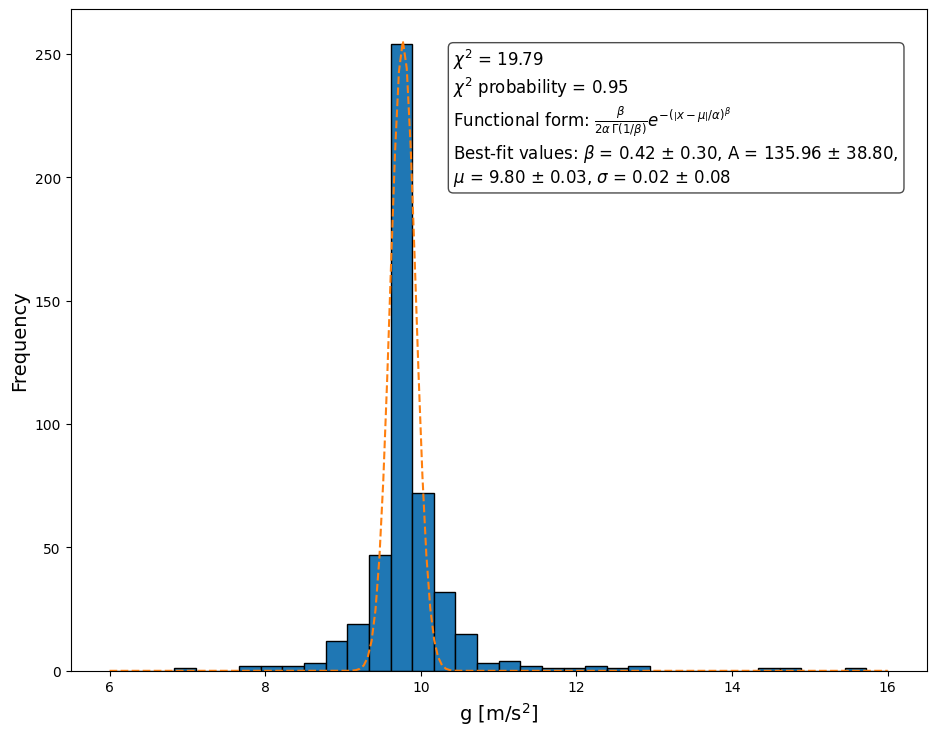

In [14]:
smooth_gaussian = gaussian(np.linspace(6, 16, num=200), *popt)
smooth_generalized_normal = generalized_normal(np.linspace(6,16,num=200),*popt2)
# smooth_gaussian = generalized_normal(np.linspace(6,16,num=200),*[0.01,*popt2[1:]])

# smooth_skew_normal = skew_normal(np.linspace(6,16,num=200),*initial_guess3)

# text_display_string_info = f"""$\\chi^2$ = {chi2_value:.2f}
# $\\chi^2$ probability = {1-chi2_prob:.2f}
# Functional form: $A e^{{-(x - \\mu)^2 / (2 \\sigma^2)}}$
# Best-fit values: A = {popt[0]:.2f} $\\pm$ {pcov[0][0]**0.5:.2f}, $\\mu$ = {popt[1]:.2f} $\\pm$ {pcov[1][1]**0.5:.2f}, $\\sigma$ = {popt[2]:.2f} $\\pm$ {pcov[2][2]**0.5:.2f}"""

text_display_string_info = f"""$\\chi^2$ = {chi2_value2:.2f}
$\\chi^2$ probability = {1-chi2_prob2:.2f}
Functional form: $\\frac{{\\beta}}{{2 \\alpha \\, \\Gamma(1/\\beta)}} e^{{-(\\left|x-\\mu\\right|/\\alpha)^\\beta}}$
Best-fit values: $\\beta$ = {popt2[0]:.2f} $\\pm$ {pcov2[0][0]**0.5:.2f}, A = {popt2[1]:.2f} $\\pm$ {pcov2[1][1]**0.5:.2f},
$\\mu$ = {popt2[2]:.2f} $\\pm$ {pcov2[2][2]**0.5:.2f}, $\\sigma$ = {popt2[3]:.2f} $\\pm$ {pcov2[3][3]**0.5:.2f}"""


fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(data, bins=bins, edgecolor='black')
ax.plot(np.linspace(6, 16, num=200), smooth_gaussian, linestyle='--')
# ax.plot(np.linspace(6, 16, num=200), smooth_generalized_normal, color = 'green',linestyle='--')
# ax.plot(np.linspace(6, 16, num=200), smooth_skew_normal, color='orange',linestyle='--')


ax.set_xlabel("g [m/s$^2$]", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

# Add anchored text in the upper right corner
fig.text(
    0.485, 0.9,  # position relative to the figure, not just the axis
    text_display_string_info,
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

plt.tight_layout(pad=3.0)  
# plt.show()

plt.savefig("JLab_Hist_AS6.pdf")
# Annotate the plot with text indicating the 
# , the prob    ability of this 
# , the functional form being fit, the best-fit values of the parameters, and the uncertainty in those best-fit values.
# Play with the parameters of your plot, including colors, line thickness and style, and so forth until the plot optimally represents what you feel are the essential properties of this data.